This notebook has to run in an environment with SAM, on Windows it will require WSL.

In [34]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tifffile import imread
from skimage.color import gray2rgb
import pickle as pkl
import dask.array as da
from tqdm import tqdm

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

from utils import tile_image

import torch
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda")

torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [45]:
im_path = r'/mnt/cbi/Jonathan/CLEM/Birder/88EM87C 25x25_ashlar.ome.tif'
output_dir = r'/mnt/d/data_analysis/2025_Birder_mito/C_00_analysis'
annotation_file = r'discard_regions.pkl'

sam2_checkpoint = "/home/kasia/sam/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

In [53]:
store = imread(im_path, aszarr=True)
im_org = da.from_zarr(store,3).compute()
im_org.shape

(2761, 3659)

In [47]:
# load polygons of annotated regions
annotation_file_path = os.path.join(output_dir, annotation_file)

with open(annotation_file_path, 'rb') as f:
    annotations = pkl.load(f)

In [54]:
from skimage.draw import polygon

for poly in annotations:
    rr, cc = polygon(poly[:, 0], poly[:, 1], im_org.shape)
    im_org[rr, cc] = 0

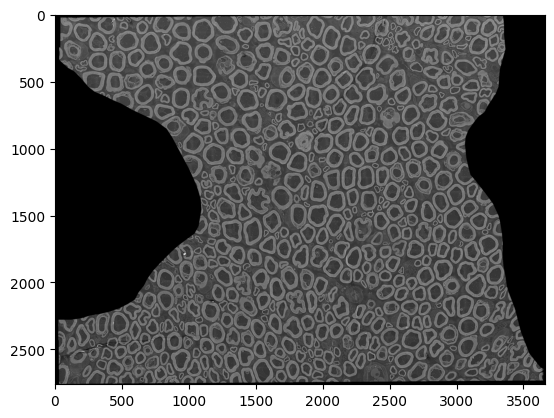

In [55]:
plt.imshow(gray2rgb(im_org))

In [19]:
# build the model
sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=64,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.9,
    stability_score_offset=0.7,
    crop_n_layers=2,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=300,
    use_m2m=False,
)

In [60]:
tile_size_x = 1024
tile_size_y = 1024
tile_overlap_x = 300
tile_overlap_y = 300

# tile the image
tiles, coords = tile_image(im_org, tile_size_x, tile_size_y, tile_overlap_x, tile_overlap_y)

for tile,coord in tqdm(zip(tiles, coords), total=len(tiles)):

    if np.max(tile) == 0:
        continue    

    masks = mask_generator_2.generate(gray2rgb(tile))

    df = pd.DataFrame(masks)
    df = df[((df['area'] > 200) & (df['area'] < 20000))]

    df['tile_row_start'] = coord[1]
    df['tile_row_end'] = coord[0]
    df['tile_col_start'] = coord[3]
    df['tile_col_end'] = coord[2]

    # save the masks
    file_name = f"tile_masks_{str(coord[1]).zfill(5)}_{str(coord[0]).zfill(5)}.pkl"
    df.to_pickle(os.path.join(output_dir, file_name))

  4%|▍         | 1/24 [00:20<07:57, 20.74s/it]/home/kasia/sam/sam2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/home/kasia/sam/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(
  8%|▊         | 2/24 [00:43<07:57, 21.72s/it]/home/kasia/sam/sam2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/home/kasia/sam/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/b